## Amazon Timestream With SageMaker
This is a sample notebook that lets Sagemaker integrate machine learning models
with Amazon Timestream.

In this notebook, we will use Climate data Analysis notebookto visualize Climate data, 
visualize Anamoly scores, 
train a Random Cut Forest (RCF) model using the Climate Records history etc.

In [65]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
import timestreamquery as timestream
from IPython import display
import pandas as pd
import boto3
import botocore
import sagemaker
import sys

#################################################
##### Timestream Configurations.  ###############
#################################################
ENDPOINT = "us-east-1" # <--- specify the region service endpoint
PROFILE = "default" # <--- specify the AWS credentials profile
DB_NAME = "testdb" # <--- specify the database created in Amazon Timestream
TABLE_NAME = "climatetable" # <--- specify the table created in Amazon Timestream

client = timestream.createQueryClient(ENDPOINT, profile=PROFILE)

#################################################
##### SageMaker Configurations. #################
#################################################

bucket = 'ccc.s3'   # <--- specify a bucket you have access to
prefix = 'ts'
execution_role = sagemaker.get_execution_role()
    
# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("You don't have permission to access the bucket, {}".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))

us-east-1
Training input/output will be stored in: s3://ccc.s3/ts


## A helper function to visualize Anomaly scores

In [4]:
def visualizeDataAndAnomalyScores(data, primary, secondary, primaryLabel = 'CPU User', secondaryLabel = 'Anomaly Score'):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(data[primary], color='C0', alpha=0.8)
    ax2.plot(data[secondary], color='C1')

    ax1.grid(which='major', axis='both')

    ax1.set_ylabel(primaryLabel, color='C0')
    ax2.set_ylabel(secondaryLabel, color='C1')

    ax1.tick_params('y', colors='C0')
    ax2.tick_params('y', colors='C1')

    ax1.set_ylim(0, 100)
    ax2.set_ylim(0, 10)
    fig.set_figwidth(10)

## Logical view of data ##
```sql
DESCRIBE <db_name>.<table_name>
```

In [5]:
query = """
DESCRIBE {}.{}
""".format(DB_NAME, TABLE_NAME)

result = timestream.executeQueryAndReturnAsDataframe(client, query, True)

display.display(result)

QueryId: AEBQEAM52TIGVLPAW3GZYHOMQAGEM3ZRIX2LXYPZHWD4MDRRUOIUL6J7BX43ZCA
2021-07-25 22:08:28. QueryId: AEBQEAM52TIGVLPAW3GZYHOMQAGEM3ZRIX2LXYPZHWD4MDRRUOIUL6J7BX43ZCA Time: 1.106. First result: 1.106. Time to read results: 0.0.


,Column,Type,Timestream attribute type
0,measure_value::double,double,MEASURE_VALUE
1,measure_name,varchar,MEASURE_NAME
2,time,timestamp,TIMESTAMP
3,Lon,varchar,DIMENSION
4,City,varchar,DIMENSION
5,Lat,varchar,DIMENSION


## Raw query: Visualize the raw data, schema.


* We can run queries at nanosecond level precision
* The query is operating on raw data, rather than any aggregated view.

In [69]:
query = """
SELECT *
FROM {}.{} 
WHERE measure_name = 'max_temp' 
    AND time > ago(100d)
LIMIT 100
""".format(DB_NAME, TABLE_NAME)

result = timestream.executeQueryAndReturnAsDataframe(client, query, True)

display.display(result)

QueryId: AEBQEAM52V4WUWIKXSLPMC333HDX73BGSFGOHFZYYNEEGJ4JYOVHMAOIENVXZQI
2021-07-26 00:57:23. QueryId: AEBQEAM52V4WUWIKXSLPMC333HDX73BGSFGOHFZYYNEEGJ4JYOVHMAOIENVXZQI Time: 0.847. First result: 0.847. Time to read results: 0.0.


,measure_value::double,measure_name,time,Lon,City,Lat
0,18.8,max_temp,2021-04-18 00:00:00.000000000,144.95,Melbourne,-37.8
1,20.8,max_temp,2021-04-19 00:00:00.000000000,144.95,Melbourne,-37.8
2,19.1,max_temp,2021-04-20 00:00:00.000000000,144.95,Melbourne,-37.8
3,15.4,max_temp,2021-04-21 00:00:00.000000000,144.95,Melbourne,-37.8
4,17.3,max_temp,2021-04-22 00:00:00.000000000,144.95,Melbourne,-37.8
...,...,...,...,...,...,...
95,11.4,max_temp,2021-07-22 00:00:00.000000000,144.95,Melbourne,-37.8
96,11.0,max_temp,2021-07-23 00:00:00.000000000,144.95,Melbourne,-37.8
97,14.1,max_temp,2021-07-24 00:00:00.000000000,144.95,Melbourne,-37.8
98,22.1,max_temp,2021-04-18 00:00:00.000000000,151.2,Sydney,-33.85


## Fetch the Climate Records for the specified duration in the past

In [79]:
def fetchDailyRainTimeseries(duration, measure, city):
    query = """
SELECT time, City, Lat, Lon, measure_name, measure_value::double AS measure
FROM {0}.{1} 
WHERE measure_name = '{3}'
    And City = '{4}'
    AND time > ago({2})
ORDER BY time ASC
""".format(DB_NAME, TABLE_NAME, duration, measure, city)

    results = timestream.executeQueryAndReturnAsDataframe(client, query)
    results['measure'] = pd.to_numeric(results['measure'])
    results['time'] = pd.to_datetime(results["time"]).dt.date
    
    return results

DURATION = '15d'  ## Fetch Climate data in past 15 days.
daily_data = fetchDailyRainTimeseries(DURATION, 'max_temp', 'Sydney')
display.display(daily_data)

QueryId: AEBQEAM52WRXLZVSNALWOXZY2GYC2YB67JORQIN6H5A4QSGBDK2YZT3PWWEXINA


,time,City,Lat,Lon,measure_name,measure
0,2021-07-12,Sydney,-33.85,151.2,max_temp,17.5
1,2021-07-13,Sydney,-33.85,151.2,max_temp,19.4
2,2021-07-14,Sydney,-33.85,151.2,max_temp,16.5
3,2021-07-15,Sydney,-33.85,151.2,max_temp,22.2
4,2021-07-16,Sydney,-33.85,151.2,max_temp,18.9
5,2021-07-17,Sydney,-33.85,151.2,max_temp,14.7
6,2021-07-18,Sydney,-33.85,151.2,max_temp,18.6
7,2021-07-19,Sydney,-33.85,151.2,max_temp,15.9
8,2021-07-20,Sydney,-33.85,151.2,max_temp,15.7
9,2021-07-21,Sydney,-33.85,151.2,max_temp,14.6


## Select the Climate Records for the past several days

In [80]:
DURATION = '300d'  ## Fetch CPU utilization for the past 7 days.

daily_data = fetchDailyRainTimeseries(DURATION, 'max_temp', 'Sydney')

display.display(daily_data)

QueryId: AEBQEAM52WSE637MCW2Y33MLEREBXATYY7V6TDRGTWZGAFUMTYLUXFK3FAIF3ZI


,time,City,Lat,Lon,measure_name,measure
0,2021-01-01,Sydney,-33.85,151.2,max_temp,21.7
1,2021-01-02,Sydney,-33.85,151.2,max_temp,22.0
2,2021-01-03,Sydney,-33.85,151.2,max_temp,26.3
3,2021-01-04,Sydney,-33.85,151.2,max_temp,28.1
4,2021-01-05,Sydney,-33.85,151.2,max_temp,28.2
...,...,...,...,...,...,...
200,2021-07-20,Sydney,-33.85,151.2,max_temp,15.7
201,2021-07-21,Sydney,-33.85,151.2,max_temp,14.6
202,2021-07-22,Sydney,-33.85,151.2,max_temp,17.4
203,2021-07-23,Sydney,-33.85,151.2,max_temp,17.1


## Visualize the Climate Time Series Data

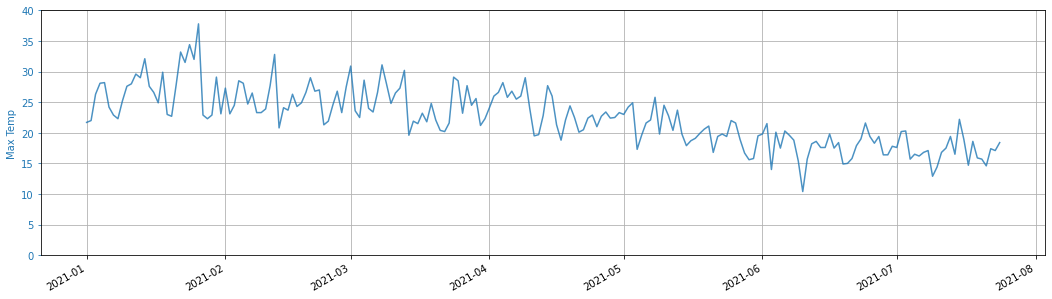

In [85]:
import matplotlib.dates as mdates

fig, ax1 = plt.subplots()

ax1.plot(daily_data['time'],daily_data['measure'], color='C0', alpha=0.8)
ax1.grid(which='major')
ax1.set_ylabel('Max Temp', color='C0')
ax1.tick_params('y', colors='C0')
fmt_half_year = mdates.MonthLocator(interval=6)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax1.xaxis.set_minor_locator(fmt_month)
ax1.xaxis.set_major_locator(fmt_month)
ax1.format_xdata = mdates.DateFormatter('%Y-%m')

ax1.set_ylim(0, 40)
fig.set_figwidth(18)
fig.autofmt_xdate()

## Train a Random Cut Forest (RCF) model using the Climate Records

Amazon SageMaker Random Cut Forest (RCF) is an unsupervised algorithm for detecting anomalous data points within a data set. These are observations which diverge from otherwise well-structured or patterned data. Anomalies can manifest as unexpected spikes in time series data, breaks in periodicity, or unclassifiable data points. 

Additional details about the random cut forestt algorithm can be found in the [RCF Algorithm documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html).

Particular to a SageMaker RCF training job are the following hyperparameters:

* **num_samples_per_tree** - the number randomly sampled data points sent to each tree. As a general rule, 1/num_samples_per_tree should approximate the the estimated ratio of anomalies to normal points in the dataset.
* **num_trees** - the number of trees to create in the forest. Each tree learns a separate model from different  samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.
* **feature_dim** - the dimension of each data point.

In addition to these RCF model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role.

## Train a Random Cut Forest (RCF) model using the Climate Records

In [66]:
from sagemaker import RandomCutForest

rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(daily_data.measure.values.reshape(-1,1)))

print('Training job name: {}'.format(rcf.latest_training_job.job_name))

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2021-07-25 23:13:51 Starting - Starting the training job...
2021-07-25 23:14:15 Starting - Launching requested ML instancesProfilerReport-1627254831: InProgress
......
2021-07-25 23:15:21 Starting - Preparing the instances for training.........
2021-07-25 23:16:52 Downloading - Downloading input data
2021-07-25 23:16:52 Training - Downloading the training image.....Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/25/2021 23:17:34 INFO 139908004284224] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '', '_ftp_port': 8999}
[07/25/2021 23:17:34 INFO 139908004284224] Merging with provided

## Deploy the model for inference
We create an inference endpoint using the SageMaker Python SDK deploy() function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up. We recommend using the ml.c5 instance type as it provides the fastest inference time at the lowest cost.

In [ ]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

print('Endpoint name: {}'.format(rcf_inference.endpoint))